In [262]:
import numpy as np
import matplotlib.pyplot as plt
#scipy cwt
import scipy
import sys
import os
from ssqueezepy import ssq_cwt
sys.path.append(os.path.dirname(os.getcwd()))
sys.path.append(os.path.dirname(os.getcwd()) + "/../../../../.")

from wavelib.python.wavelibh import WavelibH
wavelib_as = WavelibH('../../../../../wavelib/python/libwavelibwrapper.so')


def exponential_smoothing(data, alpha):
    smoothed_data = np.zeros_like(data)
    smoothed_data[0] = data[0]  # Initial condition

    for t in range(1, len(data)):
        smoothed_data[t] = alpha * data[t] + (1 - alpha) * smoothed_data[t-1]

    return smoothed_data

DECIMATION = 2 #by how much to decimate the signal of 20khz

INTERP_SIZE = 50
SAMPLE_LEN = 200

SCALES = 10 #cwt scales
MORLET = 4
DT = 1
DJ = 0.1*3 #spacing between scales
S0 = 2.5*DT #smallest scale
POW = 2 
REFERENCE = 0.01

'''
s0 is the smallest scale, 
while dj is the separation between scales. 
Dj can also be seen as a measure of resolution which is calculated as dj = 1.0 
Number of subscales so smaller value of dj corresponds to higher resolution within a scale.
type accepts “pow”/”power” or “lin”/”linear” as input values, power is the base of power
 if “pow”/”power' is selected and is ignored if the input is “lin”. Power of N scale calculation.
'''

def get_image(timeseries):
    assert len(timeseries) == N
    linear_scale_type = 0
    
    cwt = wavelib_as.cwt(timeseries, S0, DJ, linear_scale_type, POW, MORLET, DT, SCALES)
    cwt = (cwt/REFERENCE)
    cwt = np.repeat(cwt, 5, axis=0)
    cwt = cwt[:,::4]
    
    assert cwt.shape == (INTERP_SIZE, INTERP_SIZE)
    
    return cwt

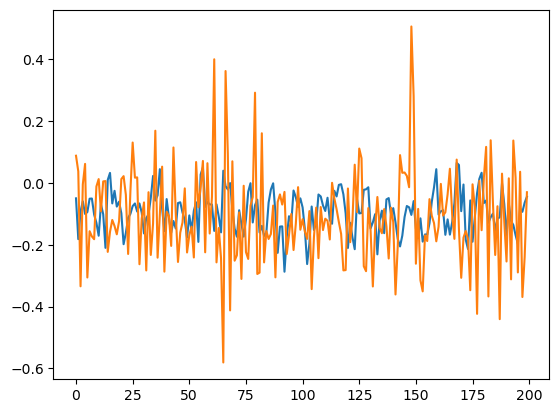

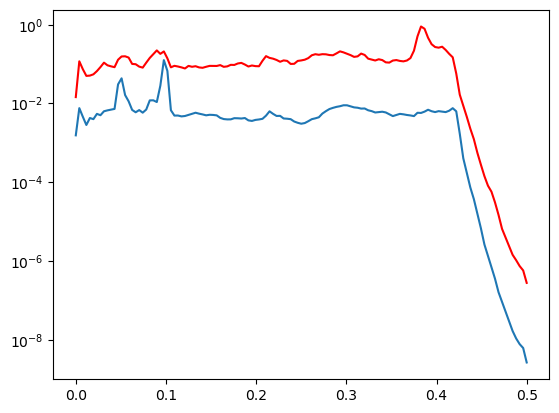

In [245]:
all_normal_signal = np.loadtxt('exp1_b3_ch5_first100k.txt')
all_fault_signal = np.loadtxt('exp1_b3_ch5_last100k.txt')

#first decimate the signals by 2
all_normal_signal = scipy.signal.decimate(all_normal_signal, DECIMATION)
all_fault_signal = scipy.signal.decimate(all_fault_signal, DECIMATION)

#all_normal_signal = np.round(all_normal_signal*2**2)
#all_fault_signal = np.round(all_fault_signal*2**2)

smooth_all_normal_signal = exponential_smoothing(all_normal_signal, 1) #1 means no smoothing --> this yields best results
smooth_all_fault_signal = exponential_smoothing(all_fault_signal, 1)


#extract windows of 200 samples from the smoothed signals
normal_signals = []
fault_signals = []
for i in range(0, len(smooth_all_normal_signal)-SAMPLE_LEN, SAMPLE_LEN):
    normal_signals.append(smooth_all_normal_signal[i:i+SAMPLE_LEN])
    fault_signals.append(smooth_all_fault_signal[i:i+SAMPLE_LEN])


#mean_normal_signal = np.mean(np.array(normal_signals),axis=0)
#mean_fault_signal = np.mean(np.array(fault_signals),axis=0)


mean_fault_signal = np.array(fault_signals[2])
mean_normal_signal = np.array(normal_signals[9])


#standardise the signals
#mean_normal_signal = (mean_normal_signal - np.mean(mean_normal_signal))/np.std(mean_normal_signal)
#mean_fault_signal = (mean_fault_signal - np.mean(mean_fault_signal))/np.std(mean_fault_signal)

plt.plot(mean_normal_signal)
plt.plot(mean_fault_signal)

plt.figure()
#plot psd of the mean signals
f, Pxx_den = scipy.signal.welch(smooth_all_normal_signal, fs=1)
plt.semilogy(f, Pxx_den)
f, Pxx_den = scipy.signal.welch(smooth_all_fault_signal, fs=1)
plt.semilogy(f, Pxx_den, 'r')

### Copy to micro

In [234]:
# for C header file
cstring = "//generated by python script\n //params: INTERP_SIZE=%d, SCALES=%d, MORLET=%d, SAMPLE_LEN=%d\n" % (INTERP_SIZE, SCALES, MORLET, SAMPLE_LEN)
# prolog
cstring += ('double mean_normal_signal[%d] = {' % (int(SAMPLE_LEN)))
for element in mean_normal_signal:
    cstring += ('%f,' % float(element))
# epilog
cstring += ('};\n')

cstring += ('double mean_fault_signal[%d] = {' % (int(SAMPLE_LEN)))
for element in mean_fault_signal:
    cstring += ('%f,' % float(element))
# epilog
cstring += ('};')

#copy to clipboard
import pyperclip
pyperclip.copy(cstring)

compare scipy output with: https://rafat.github.io/wavelib/#/cdisplay

In [ ]:
def plot_cwts(signal, wavelib=False, normal=True):    
    VMIN = 0
    VMAX = 0.4
    BINS = 100
    
    morlet_mu = MORLET
    dt=1
    wavelib_scales = np.array([2.000000, 2.804027, 3.931282, 5.511710, 7.727491, 10.834045, 15.189475, 21.295845, 29.857058, 41.859991, 58.688264, 82.281725,]) #wavelib generates this for us, we extracted it from the microcontroller
    wavelib_dj = 0.487500 #Separation between scales. eg., scale = s0 * 2 ^ ( [0:N-1] *dj ) or scale = s0 *[0:N-1] * dj
    wavelib_J = SCALES #scales
    
    ssqcwt_scales = np.exp(np.linspace(np.log(wavelib_scales)[0], np.log(wavelib_scales)[-1], SCALES)) #= log(wavelib_scales)

    wavelib_as_mag = wavelib_as.cwt(signal, morlet_mu, dt, wavelib_J)
    

    scipy_cwt = scipy.signal.cwt(signal, scipy.signal.morlet2,widths=wavelib_scales, w=morlet_mu)
    scipy_cwt = np.abs(scipy_cwt)

    if wavelib:
        if normal:
            wavelib_cwt = np.loadtxt("cwt_output_bearings_avg_normal.txt")
        else:
            wavelib_cwt = np.loadtxt("cwt_output_bearings_avg_fault.txt")
        
        wavelib_cwt = wavelib_cwt.reshape((wavelib_J,SAMPLE_LEN))
        


    t, w, *_= ssq_cwt(signal, ('morlet', {'mu': morlet_mu}), scales = ssqcwt_scales)
    w = np.abs(w)

    ################################################################################################################
    #                                                  plot CWT 
    ################################################################################################################
    #make a subplot, scipy on left, rafat.github.io/wavelib on right (with titles)
    plt.figure(figsize=(25, 5))
    plt.subplot(1, 4, 1)
    plt.title('scipy cwt')
    plt.imshow(scipy_cwt, aspect='auto', cmap='turbo', vmin=VMIN, vmax=VMAX)

    #ssq cwt
    plt.subplot(1, 4, 2)
    plt.title('ssqueezepy cwt')
    plt.imshow(w, aspect='auto', cmap='turbo', vmin=VMIN, vmax=VMAX)
    

    if wavelib:

        plt.subplot(1, 4, 3)
        plt.title('rafat.github.io/wavelib cwt on ARM Cortex M4\n+ bilinear interp')
        print(wavelib_cwt.shape)
        wavelib_cwt = wavelib_cwt.flatten()
        wavelib_cwt = wavelib_as.bilinear_interpolate(wavelib_cwt, SCALES, SAMPLE_LEN, INTERP_SIZE, INTERP_SIZE)
        plt.imshow(wavelib_cwt, cmap='turbo', vmin=VMIN, vmax=VMAX,interpolation='none')
        
        
        plt.subplot(1, 4, 4)
        plt.title('rafat.github.io/wavelib cwt on Apple Silicon\n+ bilinear interp')
        
        
        wavelib_as_mag = wavelib_as_mag.flatten()
        wavelib_as_mag = wavelib_as.bilinear_interpolate(wavelib_as_mag, SCALES, SAMPLE_LEN, INTERP_SIZE, INTERP_SIZE)
        print(np.max(wavelib_as_mag), np.std(wavelib_as_mag) , np.min(wavelib_as_mag))

    
        plt.imshow(wavelib_as_mag, cmap='turbo', vmin=VMIN, vmax=VMAX,interpolation='none') #, interpolation='bilinear', aspect='auto'$
        
        #y axis is 0 = nyquist frequency, >8 small freqs
        #x axis is time


    ################################################################################################################
    #                                             plot histograms
    ################################################################################################################
    plt.figure(figsize=(25, 5))
    plt.subplot(1, 4, 1)
    plt.title('scipy cwt')
    plt.hist(scipy_cwt.flatten(), bins=BINS)
    plt.xlim([VMIN, VMAX])

    plt.subplot(1, 4, 2)
    plt.title('ssqueezepy cwt')
    plt.hist(w.flatten(), bins=BINS)
    plt.xlim([VMIN, VMAX])
    
        

    if wavelib:
        plt.subplot(1, 4, 3)
        plt.title('rafat.github.io/wavelib cwt on ARM Cortex M4')
        plt.hist(wavelib_cwt.flatten(), bins=BINS)
        #x axis limit
        plt.xlim([VMIN, VMAX])
        
        plt.subplot(1, 4, 4)
        plt.title('rafat.github.io/wavelib cwt on Apple Silicon')
        plt.hist(wavelib_as_mag.flatten(), bins=BINS)
        #x axis limit
        plt.xlim([VMIN, VMAX])

plot_cwts(mean_normal_signal, wavelib=True, normal=True)
print("-----")
plot_cwts(mean_fault_signal, wavelib=True, normal=False)

In [ ]:
#Somehow there is a bug  in interpolation when running on the device, see below

In [ ]:
wavelib_cwt_bilinear = np.loadtxt("cwt_output_bearings_avg_normal_bilinear.txt")
wavelib_cwt_bilinear_fault = np.loadtxt("cwt_output_bearings_avg_fault_bilinear.txt")

wavelib_cwt_bilinear = wavelib_cwt_bilinear.reshape((INTERP_SIZE,INTERP_SIZE))
wavelib_cwt_bilinear_fault = wavelib_cwt_bilinear_fault.reshape((INTERP_SIZE,INTERP_SIZE))

#histogram of the bilinear interpolated cwt
plt.figure()
plt.hist(wavelib_cwt_bilinear.flatten(), bins=100)
plt.xlim([0, 0.7])
plt.title('histogram of the bilinear interpolated cwt')

#plt imshow
plt.figure()
plt.imshow(wavelib_cwt_bilinear, cmap='turbo', vmin=0, vmax=0.7,interpolation='none')

#histogram of the bilinear interpolated cwt fault
plt.figure()
plt.hist(wavelib_cwt_bilinear_fault.flatten(), bins=100)
plt.xlim([0, 0.7])
plt.title('histogram of the bilinear interpolated cwt fault')

#plt imshow
plt.figure()
plt.imshow(wavelib_cwt_bilinear_fault, cmap='turbo', vmin=0, vmax=0.7,interpolation='none')


(50, 50)


(0.0, 10.0)

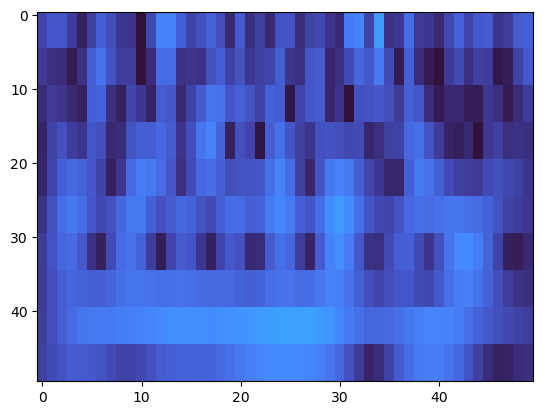

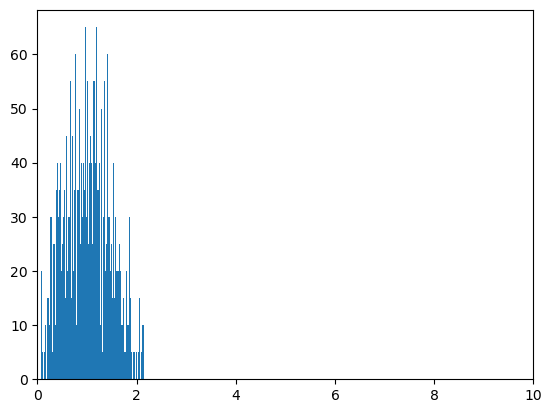

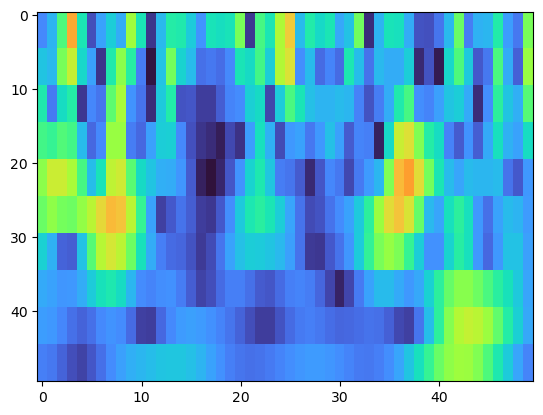

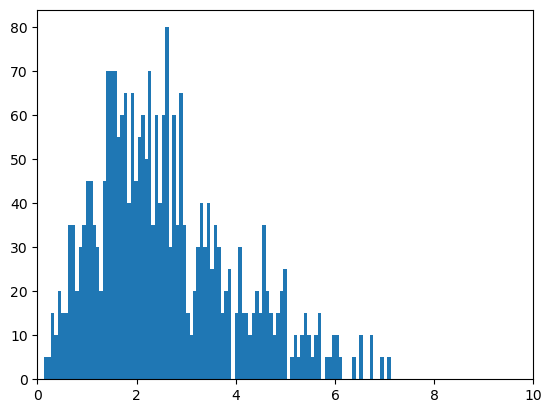

In [263]:
all_normal_signal = np.loadtxt('exp1_b3_ch5_first100k.txt')
all_fault_signal = np.loadtxt('exp1_b3_ch5_last100k.txt')


#decimate by 2 first --> per file now 20480/2
all_normal_signal = all_normal_signal[::2]
all_fault_signal = all_fault_signal[::2]

#extract 50 windows à 192 samples each
N = SAMPLE_LEN
morlet_mu = MORLET
wavelib_J = SCALES
dt=DT
NWindows=50
linear_scale_type = 0
s0=S0
dj=DJ
power=POW
REFERENCE_VALUE = REFERENCE

normal_windows = []
fault_windows = []
start = 20
for i in range(start,start+NWindows):
    normal_windows.append(all_normal_signal[i*N:(N+i*N)])
    fault_windows.append(all_fault_signal[i*N:(N+i*N)])

#create an average of those 50 windows
normal_windows_avg = np.mean(np.array(normal_windows), axis=0)
fault_windows_avg =  np.mean(np.array(fault_windows), axis=0)

assert fault_windows_avg.shape[0] == N
assert normal_windows_avg.shape[0] == N

normal_img = get_image(normal_windows_avg)
fault_img = get_image(fault_windows_avg)

print(normal_img.shape)

#compare the 2 average windows using the same color scale
plt.figure()
plt.imshow(normal_img, aspect='auto', cmap="turbo", vmax=0.1/REFERENCE)
plt.figure()
plt.hist(normal_img.flatten(), bins=100)
plt.xlim([0, 0.1/REFERENCE])


plt.figure()
plt.imshow(fault_img, aspect='auto', cmap="turbo", vmax=0.1/REFERENCE)
plt.figure()
plt.hist(fault_img.flatten(), bins=100)
plt.xlim([0, 0.1/REFERENCE])